<a href="https://colab.research.google.com/github/Supreeta11/Cardiovascular-Risk-Prediction/blob/main/Copy_of_Cardiovascular_Risk_Prediction_Supreeta_kumari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

df = pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')

In [ ]:
df.info

<bound method DataFrame.info of         id  age  education sex is_smoking  cigsPerDay  BPMeds  \
0        0   64        2.0   F        YES         3.0     0.0   
1        1   36        4.0   M         NO         0.0     0.0   
2        2   46        1.0   F        YES        10.0     0.0   
3        3   50        1.0   M        YES        20.0     0.0   
4        4   64        1.0   F        YES        30.0     0.0   
...    ...  ...        ...  ..        ...         ...     ...   
3385  3385   60        1.0   F         NO         0.0     0.0   
3386  3386   46        1.0   F         NO         0.0     0.0   
3387  3387   44        3.0   M        YES         3.0     0.0   
3388  3388   60        1.0   M         NO         0.0     NaN   
3389  3389   54        3.0   F         NO         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    221.0  148.0   85.0    NaN   
1                   0        

In [5]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [7]:
train_df.shape

(2712, 17)

In [8]:
test_df.shape

(678, 17)

## **Exploratory Data Analysis**

**Categorical Variables**

* Data cleaning-null values imputation





In [9]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [10]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_df[cat_features])
train_df[cat_features]= simp_imputer.transform(train_df[cat_features])
test_df[cat_features]= simp_imputer.transform(test_df[cat_features])

## **Education**

In [11]:
train_df.education.unique()

array([2.0, 3.0, 1.0, 4.0], dtype=object)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

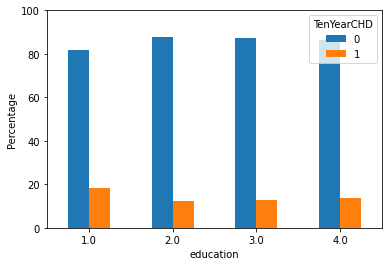

In [12]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [13]:
prob = 0.99
alpha = 1.0 - prob

In [14]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [15]:
cat_dependency(freq_df)

significance=0.010, p=0.0006802
Categorical variables are dependent


True

## **sex**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

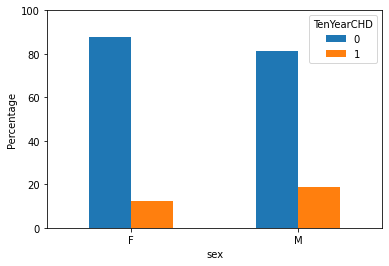

In [16]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [17]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

**Higher fraction of males are prone to cardiovascular diseases.**

# **Smoking**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

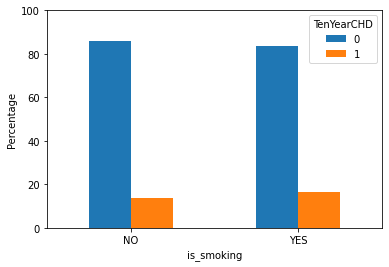

In [18]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [19]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

**statistically smoking has no impact on 10 year risk of CHD**

##**BP Meds**

In [20]:
train_df.BPMeds.unique()

array([0.0, 1.0], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

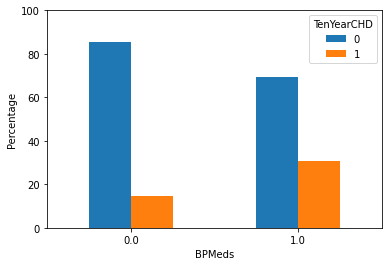

In [21]:
freq_df = train_df.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [22]:
cat_dependency(freq_df)

significance=0.010, p=0.0001078
Categorical variables are dependent


True

**People who take Blood Pressure Meds have higher chance of having CHD**

## **Prevalent Stroke**

In [23]:
train_df.prevalentStroke.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

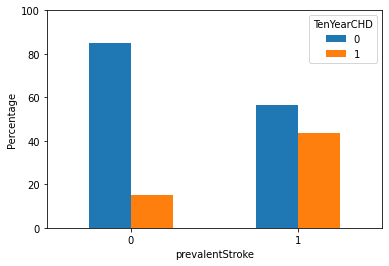

In [24]:
freq_df = train_df.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [25]:
cat_dependency(freq_df)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

**Higher percentage of patients having with prevalent stroke symptoms have a 10-year risk of CHD**

## **Prevalent Hypertension**

In [26]:
train_df.prevalentHyp.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

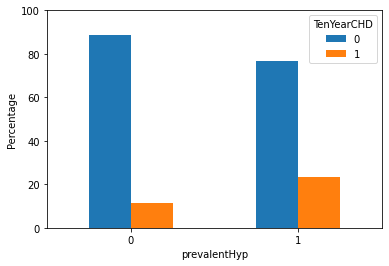

In [27]:
freq_df = train_df.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [28]:
cat_dependency(freq_df)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

**Hypertension patients are having high risk of CHD**

## **Diabetes**

In [29]:
train_df.diabetes.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

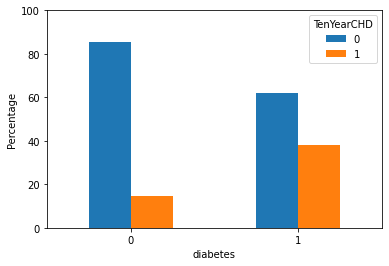

In [30]:
freq_df = train_df.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [31]:
cat_dependency(freq_df)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

**Diabetic patients tends to have higher 10 years risk of CHD**

## **Continuous Variables**

In [32]:
cont_features = ['age', 'totChol', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [33]:
knn_imputer= KNNImputer(n_neighbors=5)
knn_imputer.fit(train_df[cont_features])
train_df[cont_features]= knn_imputer.transform(train_df[cont_features])
test_df[cont_features]= knn_imputer.transform(test_df[cont_features])

## **Age**

In [34]:
train_df.age.unique()

array([49., 51., 57., 59., 52., 60., 48., 40., 54., 39., 56., 44., 42.,
       43., 41., 45., 37., 61., 53., 62., 47., 36., 55., 34., 46., 64.,
       38., 58., 63., 35., 50., 65., 67., 66., 68., 33., 69., 70., 32.])

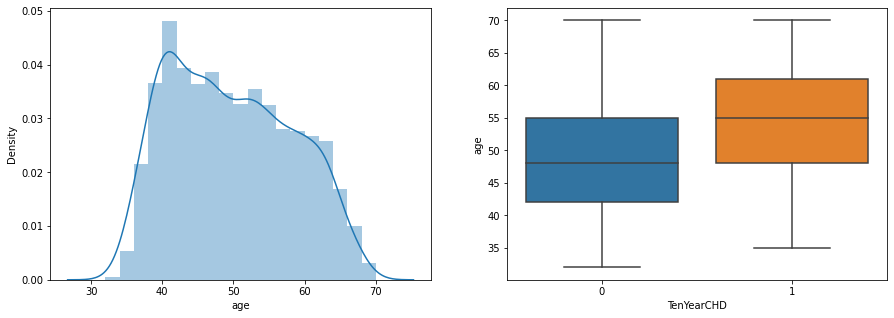

In [35]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_df, ax=axes[1])

In [36]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_df[train_df['TenYearCHD'] == 1][feature], train_df[train_df['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [37]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

## **Bucketing age features**

In [38]:
train_df['age_bucket'] = train_df['age'].apply(lambda x : 5*(x//5))

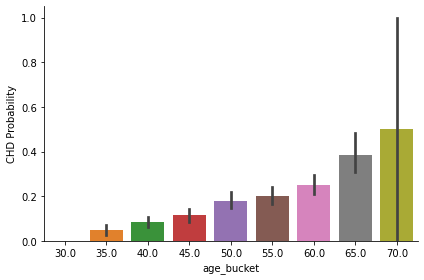

In [39]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**The positive CHD cases seems to be more prevalent in older people**

## **Cigrrettes per day**

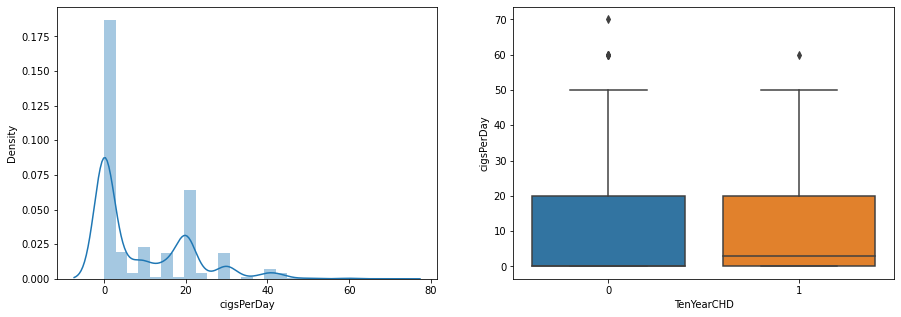

In [40]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_df, ax=axes[1])

In [41]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00184
Ten year Risk of CHD is dependent on the continuous variable


True

**We can see that medium is slightly higher for the positive cases,which means people who smoke higher number of cigrattes per day,tend to show cardiovascular**

## **Total Cholerstrol Level**

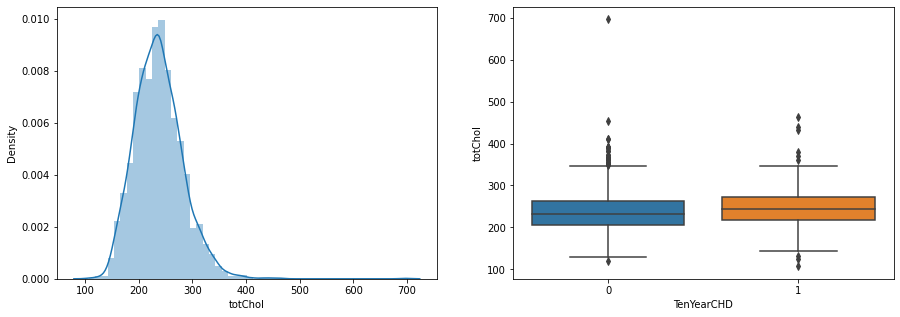

In [42]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [43]:
#dealing with outliers
vals = train_df.totChol.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['totChol'] = train_df['totChol'].apply(lambda x : x if x > min_lim and x < max_lim else train_df['totChol'].median())

0.25    206.00
0.75    264.25
Name: totChol, dtype: float64


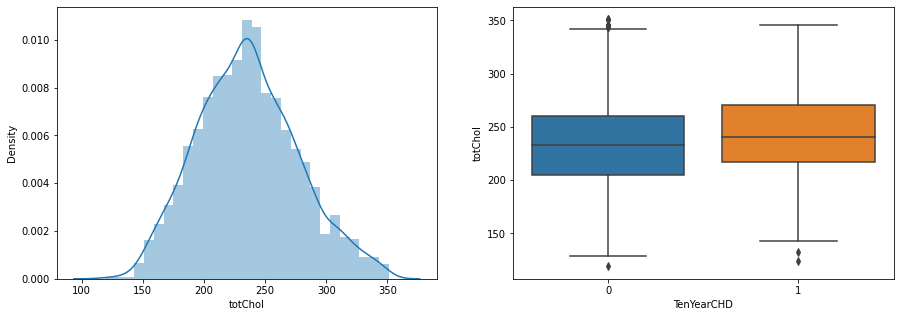

In [44]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [45]:
cont_dependency('totChol')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Total Cholerstrol Feature**

In [46]:
train_df['chol_bucket'] = train_df['totChol'].apply(lambda x : 40*(x//40))

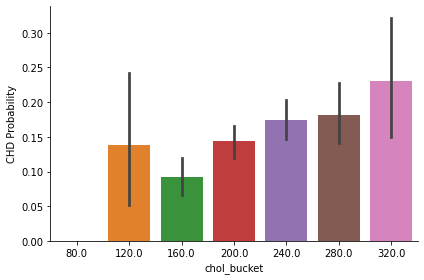

In [47]:
ax = sns.factorplot('chol_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

## **Systolic & diastolic BP**

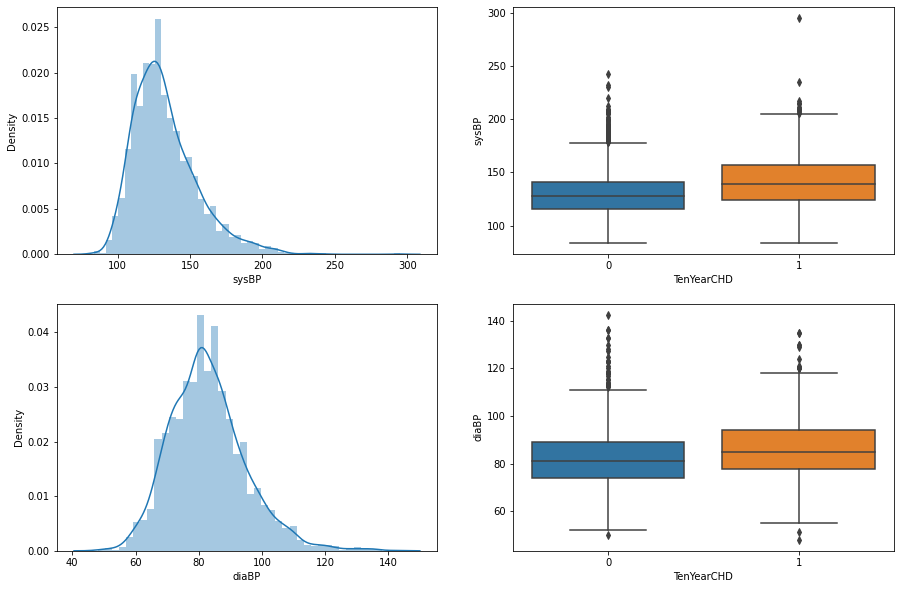

In [48]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.distplot(train_df['sysBP'], ax=axes[0,0])
sns.boxplot(y='sysBP',x='TenYearCHD',data=train_df, ax=axes[0,1])
sns.distplot(train_df['diaBP'], ax=axes[1,0])
sns.boxplot(y='diaBP',x='TenYearCHD',data=train_df, ax=axes[1,1])

In [ ]:
cont_dependency('sysBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [49]:
cont_dependency('diaBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Systolic BP Feature**

In [50]:
train_df['sysBP_bucket'] = train_df['sysBP'].apply(lambda x : 30*(x//30))

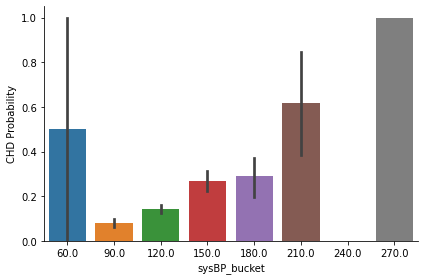

In [51]:
ax = sns.factorplot('sysBP_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**We see a slightly positive inclination of CHD risk towards high systolic & diastolic Blood Pressure**

##**Body Mass Index(BMI)**

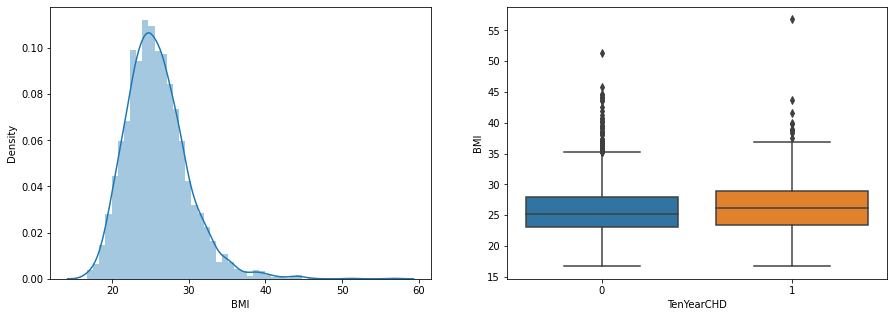

In [52]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['BMI'], ax=axes[0])
sns.boxplot(y='BMI',x='TenYearCHD',data=train_df, ax=axes[1])

In [53]:
cont_dependency('BMI')

significance=0.010, p=0.00279
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing BMI feature**

In [54]:
train_df['bmi_bucket'] = train_df['BMI'].apply(lambda x : 3*(x//3))

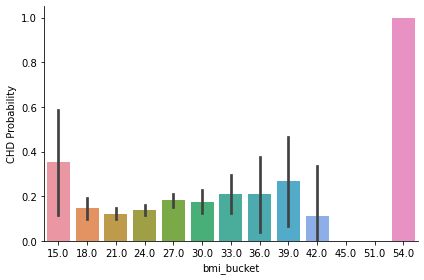

In [55]:
ax = sns.factorplot('bmi_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

## **Heart Rate**

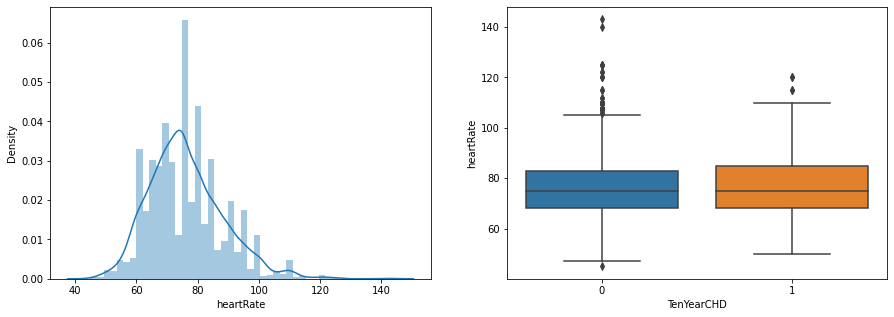

In [56]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['heartRate'], ax=axes[0])
sns.boxplot(y='heartRate',x='TenYearCHD',data=train_df, ax=axes[1])

In [57]:
cont_dependency('heartRate')

significance=0.010, p=0.16756
Ten year Risk of CHD is not dependent on continuous variable


False

**Bucketing Heart Rate Feature**

In [58]:
train_df['hr_bucket'] = train_df['heartRate'].apply(lambda x : 10*(x//10))

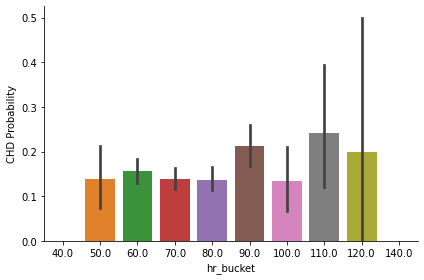

In [59]:
ax = sns.factorplot('hr_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

## **Glucose**

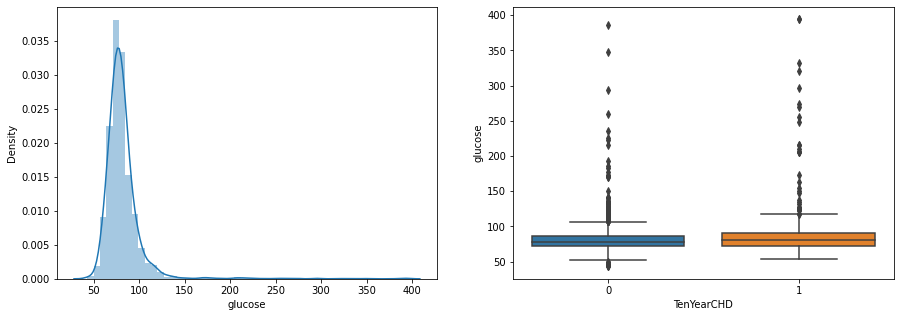

In [60]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['glucose'], ax=axes[0])
sns.boxplot(y='glucose',x='TenYearCHD',data=train_df, ax=axes[1])

In [61]:
cont_dependency('glucose')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [62]:
train_df['glucose_bucket'] = train_df['glucose'].apply(lambda x : 50*(x//50))

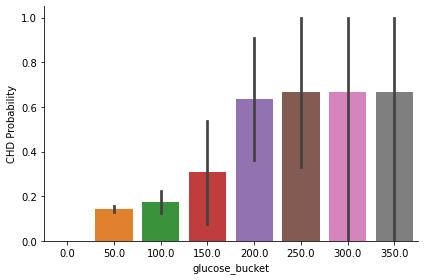

In [63]:
ax = sns.factorplot('glucose_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2712 non-null   int64  
 1   age              2712 non-null   float64
 2   education        2712 non-null   object 
 3   sex              2712 non-null   object 
 4   is_smoking       2712 non-null   object 
 5   cigsPerDay       2712 non-null   float64
 6   BPMeds           2712 non-null   object 
 7   prevalentStroke  2712 non-null   object 
 8   prevalentHyp     2712 non-null   object 
 9   diabetes         2712 non-null   object 
 10  totChol          2712 non-null   float64
 11  sysBP            2712 non-null   float64
 12  diaBP            2712 non-null   float64
 13  BMI              2712 non-null   float64
 14  heartRate        2712 non-null   float64
 15  glucose          2712 non-null   float64
 16  TenYearCHD       2712 non-null   int64  
 17  age_bucket   

### **Dependency between Independent Variables-Check for multicollinearity**

In [65]:
def cat_dependency_matrix(cols, alpha=alpha, verbose=False):
  cat_matrix = np.zeros((cols.shape[0], cols.shape[0]))
  print(cat_matrix.shape)
  for i,col in enumerate(cols):
    for j,col in enumerate(cols):
      if i != j:
        cat_matrix[i,j] = int(cat_dependency(train_df.groupby(cols[j])[cols[i]].value_counts().unstack(0), alpha=alpha, verbose=verbose))
      else:
        cat_matrix[i,j] = 1.
  return pd.DataFrame(cat_matrix, columns=cols, index=cols, dtype=int)

In [66]:
cat_cols = np.array(['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
cat_dependency_matrix(cat_cols, alpha=0.01, verbose=False)

(7, 7)


,education,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
education,1,1,1,0,0,1,1
sex,1,1,1,0,0,0,0
is_smoking,1,1,1,0,0,1,1
BPMeds,0,0,0,1,1,0,1
prevalentStroke,0,0,0,1,1,1,0
prevalentHyp,1,0,1,0,1,1,1
diabetes,1,0,1,1,0,1,1


**Let's look at correlation matrix of categorical variables as well !**

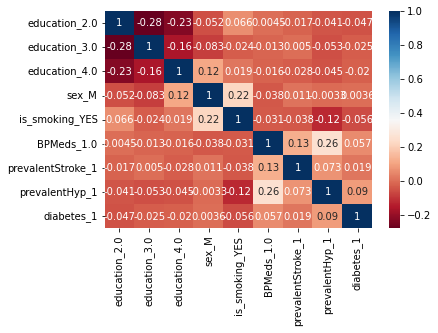

In [67]:
train_cat_df = pd.get_dummies(train_df[cat_cols], drop_first=True) 
sns.heatmap(train_cat_df.corr(), cmap='RdBu', annot=True)

In [68]:
#lets check vif scores
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [69]:
ignore_features = ['education']
train_cat_df_ = train_cat_df[[col for col in train_cat_df.columns if col not in ignore_features]]
calc_vif(train_cat_df_)

,variables,VIF
0,education_2.0,0.006790
1,education_3.0,0.480280
2,education_4.0,0.213605
3,sex_M,0.198403
4,is_smoking_YES,0.086462
5,BPMeds_1.0,1.123641
6,prevalentStroke_1,1.025972
7,prevalentHyp_1,0.127765
8,diabetes_1,1.030739


**Based on VIF scores,I can safely remove education feature.**

**Let's look at correlation matrix of continuous variables.**

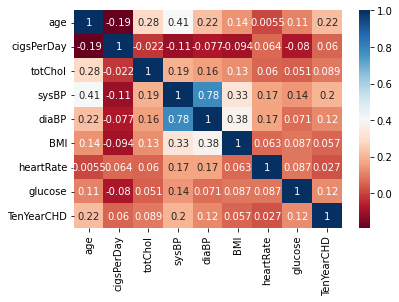

In [70]:
cont_cols = np.array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'])
sns.heatmap(train_df[cont_cols].corr(), cmap='RdBu', annot=True)

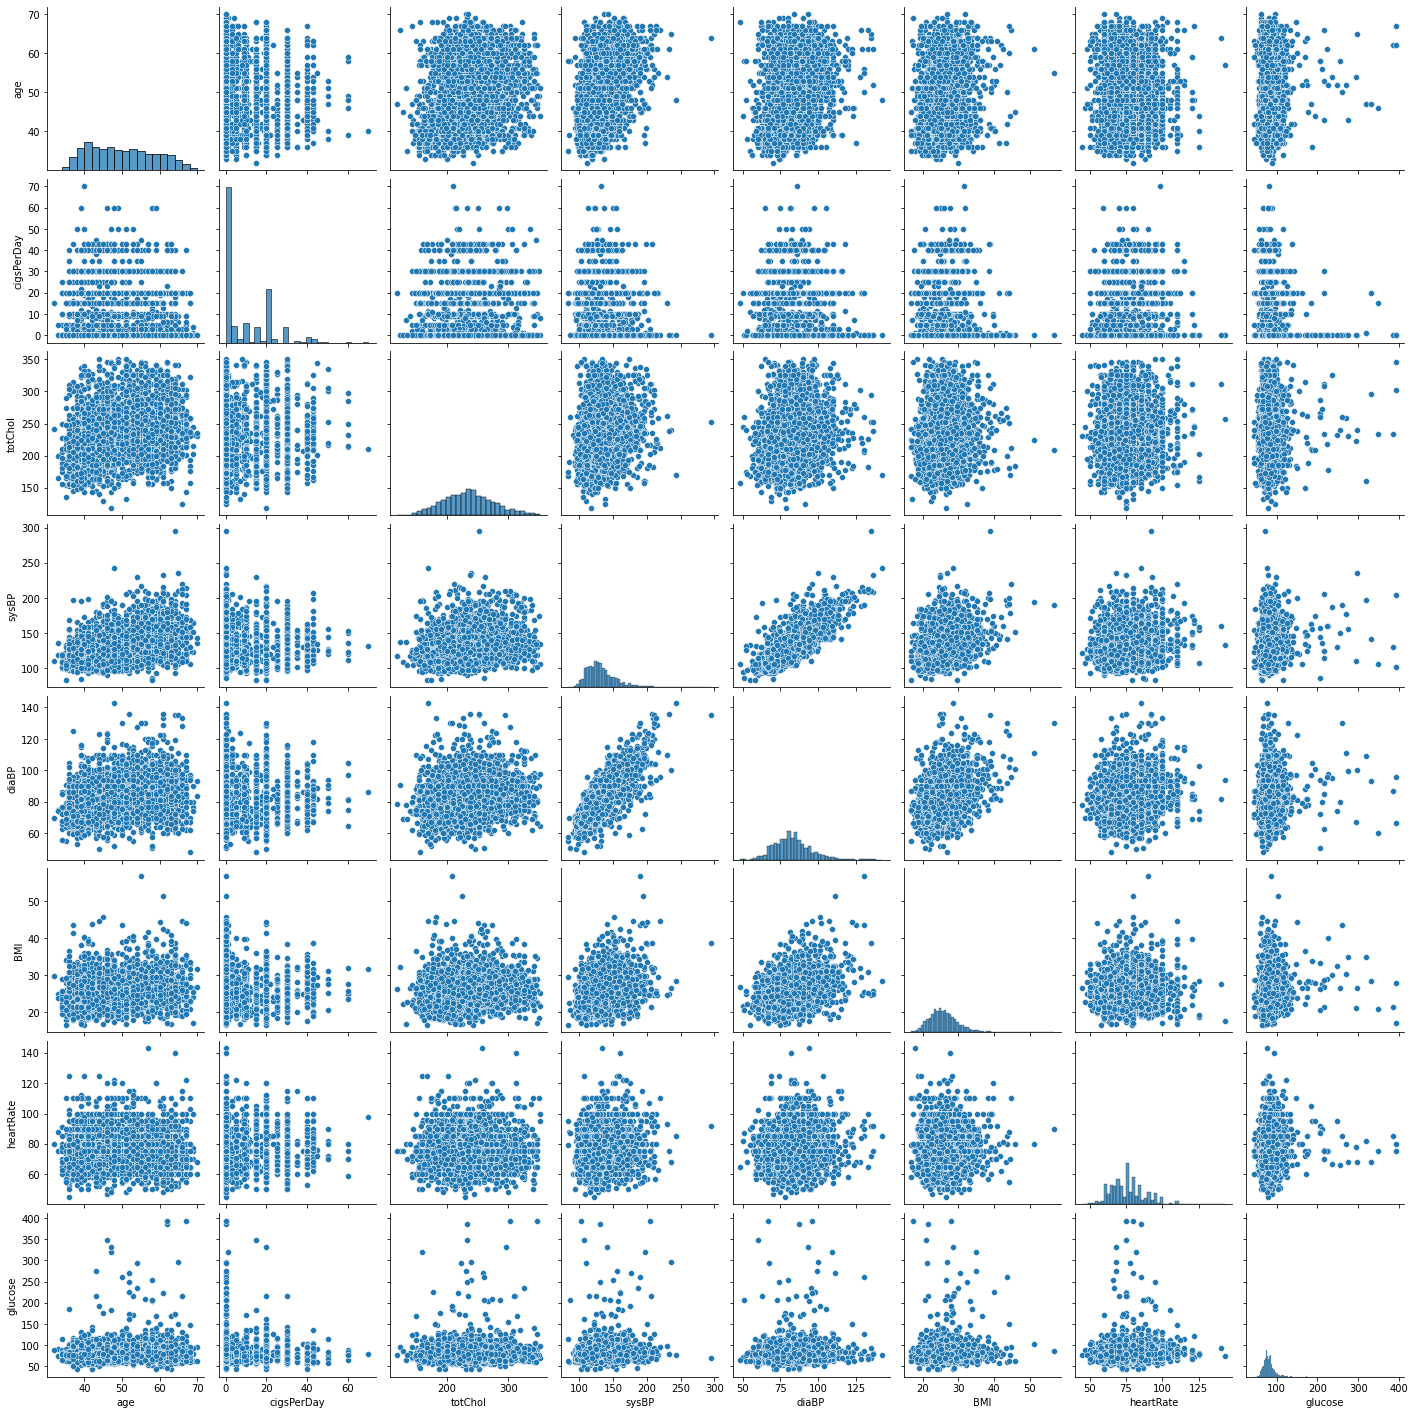

In [71]:
sns.pairplot(train_df[cont_cols[:-1]])

In [72]:
ignore_features = ['TenYearCHD','diaBP']
train_cont_df = train_df[[col for col in cont_cols if col not in ignore_features]]
calc_vif(train_cont_df)

,variables,VIF
0,age,41.049805
1,cigsPerDay,1.621425
2,totChol,34.108171
3,sysBP,49.471280
4,BMI,39.070687
5,heartRate,33.297511
6,glucose,13.291682


**There was a significantly higher correlation between systolic BP and diastolic BP .Based on correlation matrix & VIF scores,I safely remove diastolic BP feature.**

**Lets look at the correlation matrix of all remaining features and see if there are any correlation left.**

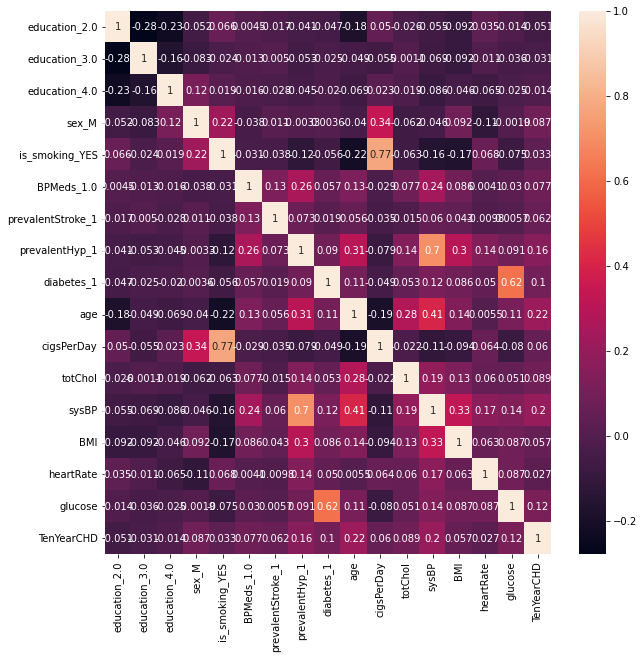

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
tot_df = pd.concat((train_cat_df_, train_cont_df, train_df['TenYearCHD']), axis =1)
sns.heatmap(tot_df.corr(), annot=True, ax= ax)

**There is significant correlation between sysBP, prevalent hypertension and age. Also features like is smoking and ciggarettes per day are correlated. Similarly glucose level and diabetes are correlated. Based on the EDA done earlier, smoking and heart Rate seem to have little to no impact on the target variable.**

**Preparing Final dataset**

In [1]:
final_features = np.concatenate((train_cat_df_.columns.values, train_cont_df.columns.values, ['education','diaBP','TenYearCHD']))

NameError: ignored

In [86]:
#imputer = KNNImputer(n_neighbors=5)
final_train_df = pd.get_dummies(train_df,drop_first=True)[final_features]
#s = imputer.fit_transform(final_train_df)
#final_train_df = pd.DataFrame(s, columns = final_train_df.columns)

KeyError: ignored

In [ ]:
final_train_df.head()

In [ ]:
final_train_df.info()

**Preparing our test dataset based on the selected features & the imputed missing values from training dataset.**

In [ ]:
final_test_df = pd.get_dummies(test_df,drop_first=True)[final_features]
#s = imputer.transform(final_test_df)
#final_test_df = pd.DataFrame(s, columns = final_test_df.columns)

In [ ]:
X_train, y_train = final_train_df.iloc[:,:-1], final_train_df.iloc[:,-1]
X_test, y_test = final_test_df.iloc[:,:-1], final_test_df.iloc[:,-1]

In [ ]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns)

### **ML modelling & addressing Class imbalance**

**Logistic Regression**

*   Random oversampler + Logistic Regression




In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
lr_model = LogisticRegression().fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

*  **StratifiedKFold + Oversampling + Logistic regression**

In [ ]:
lr_model = LogisticRegression()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  lr_model.fit(X_ros, y_ros)
  lr_predict = lr_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, lr_predict))
  i+=1
 
lr_y_predict = lr_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))



*   **SMOTE + Logistic Regression**




In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
lr_model = LogisticRegression().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))



*   **GridSearch CV on Logistic**



In [ ]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [ ]:
lr_model = LogisticRegression()
grid_model = GridSearchCV(lr_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_smote,y_smote)

In [ ]:
grid_model.best_params_

In [ ]:
lr_model = grid_model.best_estimator_

In [ ]:
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(lr_fpr, lr_tpr))
plt.legend()
plt.show()

**K-Nearest Neighbours**

*   **RandomSampler + KNN**



In [76]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

NameError: ignored

In [77]:
knn_model = KNeighborsClassifier(weights='uniform').fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

NameError: ignored


*   **StratifiedKFold + Oversampling + KNN**




In [78]:
 knn_model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  knn_model.fit(X_ros, y_ros)
  knn_predict = knn_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, knn_predict))
  i+=1
 
knn_y_predict = knn_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))

NameError: ignored



*   **SMOTE + KNN**



In [79]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
knn_model = KNeighborsClassifier().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

NameError: ignored



*   **GridSearch CV on KNN**




In [80]:
params = {
    'n_neighbors' : range(3,10,1),
    'weights' : ['uniform', 'distance']
    }

In [85]:
knn_model = KNeighborsClassifier()
grid_model = GridSearchCV(knn_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

NameError: ignored

In [82]:
grid_model.best_params_

AttributeError: ignored

In [83]:
knn_model = grid_model.best_estimator_

AttributeError: ignored

In [84]:
knn_y_predict = knn_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

NameError: ignored

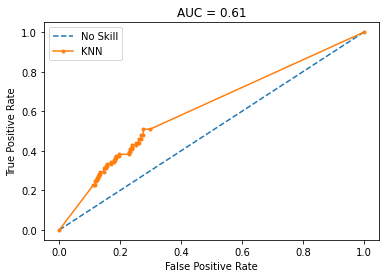

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
knn_probs = knn_model.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(knn_fpr, knn_tpr))
plt.legend()
plt.show()

**Support Vector Machine**

*   Using the imbalanced dataset in SVC  with class_weight ='balanced',ie. penalizing misclassifications in each class appropriately ! 







In [ ]:
# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)
 
svc_model.fit(X_train, y_train)
 
svc_predict = svc_model.predict(X_test)
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Recall score:',recall_score(y_test, svc_predict))
print('\n', classification_report(y_test, svc_predict))
print('\n', confusion_matrix(y_test, svc_predict))

ROCAUC score: 0.6661049836601307
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.68      0.78       576
           1       0.26      0.66      0.38       102

    accuracy                           0.67       678
   macro avg       0.59      0.67      0.58       678
weighted avg       0.82      0.67      0.72       678


 [[389 187]
 [ 35  67]]




*   **Random Oversampler + SVC**



In [ ]:
svc_model = SVC(probability=True).fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6984272875816995
Recall score: 0.7058823529411765

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.29      0.71      0.41       102

    accuracy                           0.69       678
   macro avg       0.61      0.70      0.60       678
weighted avg       0.83      0.69      0.74       678


 [[398 178]
 [ 30  72]]




*   **StratifiedKfold + Oversampling + SVC**



In [ ]:
 svc_model = SVC(probability=True)
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  svc_model.fit(X_ros, y_ros)
  svc_predict = svc_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, svc_predict))
  i+=1
 
svc_y_predict = svc_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

CV 1:  0.5609756097560976
CV 2:  0.7317073170731707
CV 3:  0.5308641975308642
CV 4:  0.5487804878048781
CV 5:  0.6341463414634146

Test results:
ROCAUC score: 0.6984272875816995
Recall score: 0.7058823529411765

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.29      0.71      0.41       102

    accuracy                           0.69       678
   macro avg       0.61      0.70      0.60       678
weighted avg       0.83      0.69      0.74       678





*   **SMOTE + SVC**




In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
svc_model = SVC(probability=True).fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6626327614379085
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.67      0.77       576
           1       0.26      0.66      0.37       102

    accuracy                           0.67       678
   macro avg       0.59      0.66      0.57       678
weighted avg       0.82      0.67      0.71       678


 [[385 191]
 [ 35  67]]




*   **GridSearchCV on SVC**




In [ ]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [ ]:
svc_model = SVC(class_weight='balanced',probability=True)
grid_model = GridSearchCV(svc_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
grid_model.best_params_

{'C': 0.01}

In [ ]:
svc_model = grid_model.best_estimator_

In [ ]:
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6725898692810457
Recall score: 0.7549019607843137

               precision    recall  f1-score   support

           0       0.93      0.59      0.72       576
           1       0.25      0.75      0.37       102

    accuracy                           0.62       678
   macro avg       0.59      0.67      0.55       678
weighted avg       0.83      0.62      0.67       678


 [[340 236]
 [ 25  77]]


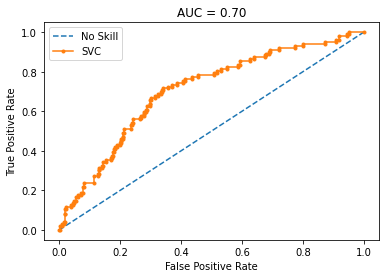

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
svc_probs = svc_model.predict_proba(X_test)
svc_probs = svc_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(svc_fpr, svc_tpr))
plt.legend()
plt.show()

**XGBoost Classifier**



*   **Over-Sampler + XGBoost**



In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
 
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
xgb_model = XGBClassifier(probability=True).fit(X_ros,y_ros)
xgb_y_predict = xgb_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

ROCAUC score: 0.6358762254901961
Recall score: 0.5686274509803921

               precision    recall  f1-score   support

           0       0.90      0.70      0.79       576
           1       0.25      0.57      0.35       102

    accuracy                           0.68       678
   macro avg       0.58      0.64      0.57       678
weighted avg       0.80      0.68      0.72       678


 [[405 171]
 [ 44  58]]




*   **GridSearchCV on XGBoost**




In [ ]:
params = {
  'max_depth' : range(3,11),
  'gamma' : [0.01, 0.05, 0.1, 0.5, 1.]
}

In [ ]:
xgb_model = XGBClassifier(probability=True)
grid_model = GridSearchCV(xgb_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     probability=True, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'max_depth': range(3, 11)},
      

In [ ]:
xgb_model = grid_model.best_estimator_

In [ ]:
xgb_y_predict = xgb_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

ROCAUC score: 0.5906862745098038
Recall score: 0.2647058823529412

               precision    recall  f1-score   support

           0       0.88      0.92      0.90       576
           1       0.36      0.26      0.31       102

    accuracy                           0.82       678
   macro avg       0.62      0.59      0.60       678
weighted avg       0.80      0.82      0.81       678


 [[528  48]
 [ 75  27]]


## **Conclusion**

**We have used Logistic Regression, KNN, SVC and XGBoost for modelling. Based on our observations, Support vector classifier seems to have performed better with a recall of 0.75, after some hyper-parameter tuning. However the precision of our models still remains a concern.**

**Scope for improvement : Need to work on improving the precision (currently $\sim$ 0.26) of your model to some extent !**